In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
import glob
import cartopy as cp
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import ListedColormap, BoundaryNorm
import sim_name_remap as map
import netCDF4 as nc4

In [2]:
def moving_window_smooth(data, width=1):
    data_copy = np.copy(data)
    smoothed = np.zeros(data_copy.shape)
    for ix in range(data_copy.shape[0]):
        for iy in range(data_copy.shape[1]):
            smoothed[ix,iy] = np.nanmean(data_copy[ix-width:ix+width,iy-width:iy+width])
    return smoothed  

def draw_box(ax, left, right, bot, top, col, thk):
    ax.plot([left, left], [bot, top], color=col, linewidth=thk)
    ax.plot([right, right], [bot, top], color=col, linewidth=thk)
    ax.plot([left, right], [bot, bot], color=col, linewidth=thk)
    ax.plot([left, right], [top, top], color=col, linewidth=thk) 

In [3]:

def get_avg_TOA_RF(FILES, RF_choice, SAVEDIR, aer_choice, emis_choice):

    print('***', RF_choice + ' RF for ' + aer_choice, emis_choice)
    
    SAVEFILE = SAVEDIR + aer_choice + '_' + RF_choice + '_' + emis_choice + '_RadForcing.pkl'

    if os.path.isfile(SAVEFILE):

        print('File found!  Reading...')
        
        with open(SAVEFILE, 'rb') as f: 
            TOA_RF_mean, lon, lat = pkl.load(f)

    else: 

        print('File not found, calculating...')    
        
        ncfile0 = nc4.Dataset(FILES[0])
        lon = ncfile0.variables['lon'][:]
        lat = ncfile0.variables['lat'][:]

        if RF_choice == 'SW': TOA_RF = ncfile0.variables['FSNT'][:]
        if RF_choice == 'LW': TOA_RF = -ncfile0.variables['FLNT'][:]
        if RF_choice == 'Net': TOA_RF = ncfile0.variables['FSNT'][:] - ncfile0.variables['FLNT'][:]
        
        if len(FILES) > 1:
            
            for FILE in FILES[1:]:
        
                ncfile = nc4.Dataset(FILE)

                if RF_choice == 'SW': curr_TOA_RF = ncfile.variables['FSNT'][:]
                if RF_choice == 'LW': curr_TOA_RF = -ncfile.variables['FLNT'][:]
                if RF_choice == 'Net': curr_TOA_RF = ncfile.variables['FSNT'][:] - ncfile.variables['FLNT'][:]
                
                TOA_RF = np.append(TOA_RF, curr_TOA_RF, axis=0)
    
        print(np.shape(TOA_RF))
    
        #TOA_RF_mean = moving_window_smooth(np.mean(TOA_RF, axis=0), width=1)
        TOA_RF_mean = np.mean(TOA_RF, axis=0)
    
        with open(SAVEFILE, 'wb') as f:
            pkl.dump((TOA_RF_mean, lon, lat),f)

    return TOA_RF_mean, lon, lat
    

In [4]:

def plot_global_RF(ax, RF_choice, aer_choice, wpac_region, SAVEDIR):

    # We actually need the monthly output to get these fields
    # Average from 2020 to 2022 to get a larger sample and make the plot cleaner
    # Removing ACCLIP so we get a bigger time period
    
    if aer_choice == 'MAM4':
        FILES1 = glob.glob(map.remap['MAM4_CAMS6.2_SO2_rad'])
        FILES2 = glob.glob(map.remap['MAM4_MEIC_SO2_rad'])
    if aer_choice == 'CARMA':
        FILES1 = glob.glob(map.remap['CARMA_CAMS_SO2_rad'])
        FILES2 = glob.glob(map.remap['CARMA_MEIC_SO2_rad'])
    
    TOA_RF_1, lon, lat = get_avg_TOA_RF(FILES1, RF_choice, SAVEDIR, aer_choice, 'CAMS')  # CAMS
    TOA_RF_2, lon, lat = get_avg_TOA_RF(FILES2, RF_choice, SAVEDIR, aer_choice, 'MEIC')  # MEIC
    
    TOA_RF_diff = TOA_RF_2 - TOA_RF_1  # MEIC minus CAMS
    
    #print(np.nanmean(TOA_SW_RF_diff))
    #print(np.shape(TOA_SW_RF_1))

    # Calculate the west Pacific average
    wpac_lonind0 = list(lon).index(wpac_region[0])
    wpac_lonind1 = list(lon).index(wpac_region[1])    
    wpac_latind0 = np.argmin(np.abs(lat - wpac_region[2]))   # Lat is not so nice and neat so we have to do this instead
    wpac_latind1 = np.argmin(np.abs(lat - wpac_region[3]))
    wpac_avg = str(np.mean(TOA_RF_diff[wpac_latind0:wpac_latind1+1,wpac_lonind0:wpac_lonind1+1]))[0:5]    

    # Define colorbar
    cmap = plt.get_cmap('coolwarm')
    levels = np.arange(-1,1.001,0.1)
    norm = BoundaryNorm(levels, cmap.N)

    TOA_RF_diff_cyc, lon_cyc = cp.util.add_cyclic_point(TOA_RF_diff, coord=lon)
    
    con = ax.contourf(lon_cyc, lat, TOA_RF_diff_cyc, cmap = cmap, levels = levels, norm=norm, extend = 'both', transform=ccrs.PlateCarree())
    ax.coastlines()

    draw_box(ax, wpac_region[0]-180, wpac_region[1]-180, wpac_region[2], wpac_region[3], 'gray', 1)  # Draw west Pacific box, subtract 180 to account for the central longitude on the projection

    ax.set_title(aer_choice + ' ' + RF_choice + ' IRF difference for 2010-2020')

    ax.text(x=-170, y=-80, s='Max: ' + str(np.max(TOA_RF_diff))[0:5], fontsize=10, backgroundcolor='white')
    ax.text(x=50, y=-80, s='Global Mean: ' + str(np.mean(TOA_RF_diff))[0:5], fontsize=10, backgroundcolor='white')
    ax.text(x=-80, y=-80, s='NPac Mean: ' + wpac_avg, fontsize=10, backgroundcolor='white')

    #cbaxes = fig.add_axes([0.1,0.1,0.8,0.03])
    #colorbar = plt.colorbar(con, label=aer_choice + ' ' + RF_choice + ' TOA RF Difference (MEIC minus CAMS, W m$^{-2}$)', orientation='horizontal')#, cax=cbaxes)

    return con

*** SW RF for CARMA CAMS
File found!  Reading...
*** SW RF for CARMA MEIC
File found!  Reading...
*** LW RF for CARMA CAMS
File found!  Reading...
*** LW RF for CARMA MEIC
File found!  Reading...
*** SW RF for MAM4 CAMS
File found!  Reading...
*** SW RF for MAM4 MEIC
File found!  Reading...
*** LW RF for MAM4 CAMS
File found!  Reading...
*** LW RF for MAM4 MEIC
File found!  Reading...


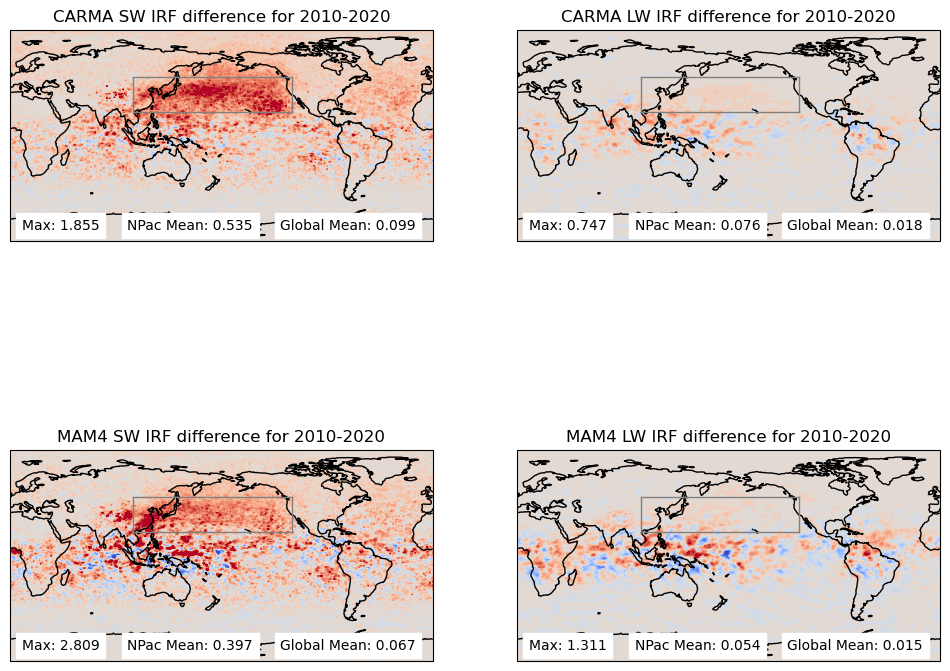

In [5]:

SAVEDIR = '/glade/derecho/scratch/wsmith/carma_vars/'
wpac_region = [105,240,20,50]

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(221, projection = ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(222, projection = ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(223, projection = ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(224, projection = ccrs.PlateCarree(central_longitude=180))

plot_global_RF(ax1, 'SW', 'CARMA', wpac_region, SAVEDIR)
plot_global_RF(ax2, 'LW', 'CARMA', wpac_region, SAVEDIR)
plot_global_RF(ax3, 'SW', 'MAM4', wpac_region, SAVEDIR)
plot_global_RF(ax4, 'LW', 'MAM4', wpac_region, SAVEDIR)


*** Net RF for CARMA CAMS
File found!  Reading...
*** Net RF for CARMA MEIC
File found!  Reading...
*** Net RF for MAM4 CAMS
File found!  Reading...
*** Net RF for MAM4 MEIC
File found!  Reading...


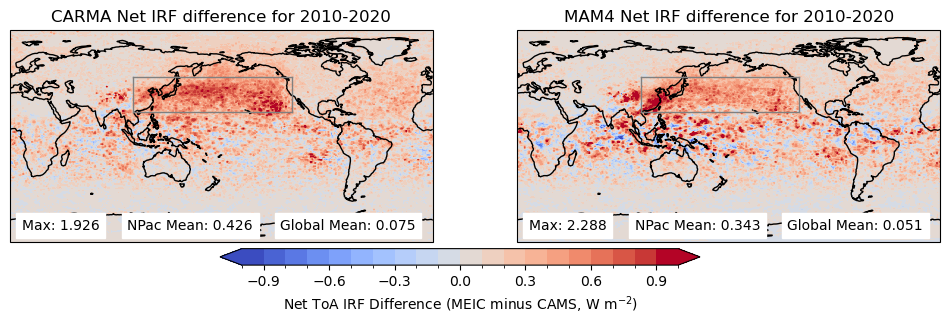

In [6]:

fig = plt.figure(figsize=(12,5.5))
ax1 = fig.add_subplot(121, projection = ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(122, projection = ccrs.PlateCarree(central_longitude=180))

RF_choice = 'Net'

con = plot_global_RF(ax1, RF_choice, 'CARMA', wpac_region, SAVEDIR)
con = plot_global_RF(ax2, RF_choice, 'MAM4', wpac_region, SAVEDIR)

cax = fig.add_axes([0.3,0.26,0.4,0.03])
colorbar = plt.colorbar(con, label= RF_choice + ' ToA IRF Difference (MEIC minus CAMS, W m$^{-2}$)', orientation='horizontal', cax=cax)

plt.savefig('/glade/u/home/wsmith/ASM_SO4_scripts/plots/Figure4.png')
plt.savefig('/glade/u/home/wsmith/ASM_SO4_scripts/plots/Figure4.pdf')
